In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
cL_df = pd.read_csv('D:/pythonTest/DataShipJo/chicken_label.csv', names=['아이디', '리뷰', 'Label'])
cL_df.sample(10)

,아이디,리뷰,Label
25674,c1**님,역시 뿌링클이죠옹ㅋㅋㅋ 최고!! 맛있게 먹었습니당^^,1
20036,ah**님,거리가 멀어서 오는데 시간이 많이 걸리네요 ㅠㅠ,1
28047,ck**님,굳 적당해요 이정도로만 나오면 최고,1
9179,cu**님,좀만더바삭햇음넘좋겟습니댜..,0
16685,09**님,너무마싯어서써요ㅎㅎ 마시이썽,1
17216,19**님,별 5개가 부족한 맛이에요,1
20765,al**님,감사합니다 수고하세요,1
13061,pi**님,맛이 궁금해서 시켜 봤는데 달콤하면서 매워요~조금 덜 매우면 좋겠지만 맛은 있어요~,0
32978,dl**님,잘먹었습니다 감사합니다!,1
32718,dl**님,bhc는 사랑입니다. 늘 먹어도 맛나요. 아이있는집이라 적당히 매운거 먹는게 좋아서...,1


In [3]:
train_data, test_data = train_test_split(cL_df, test_size = 0.2, random_state=156)

In [4]:
# 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 28217


In [5]:
# 테스트용 리뷰 개수 출력
print('테스트용 리뷰 개수:',len(test_data)) 

테스트용 리뷰 개수: 7055


In [6]:
train_data.head()

,아이디,리뷰,Label
11464,pj**님,근본의 갈반핫반!!,0
26917,ch**님,배달도 빠르고 넘나맛나요 리뷰이벤트 감사합니다 ㅎㅎ,1
29438,cw**님,역시또랴오래~예전이나지금이나너무맛나요,1
2339,rl**님,맛과 양 어느 것 하나 빠지지 않습니다~^^,0
2631,10**님,치킨에 온기가없이 식어서 왔네요 배달90분찍으시고 그것보다 빨리오셔서 그래도 식지 ...,0


In [7]:
test_data.head()

,아이디,리뷰,Label
26539,ch**님,너무 맛있어요! 계속 이맛 유지해주세용^^ 담에 또 시켜먹을래요,1
9619,mi**님,소스 추가 주문했는데 안왔어요 ㅠ,0
7429,mk**님,냠냠냠냠냠냠냠냠냠냠냠냠냠,0
23639,be**님,양도 많고 음식도 맛있어요.,1
15015,ni**님,배송빨라서 치킨 바삭바삭,0


## 데이터 중복 유무 확인

In [8]:
# '리뷰'열과 'Label'열의 중복을 제외한 값의 개수
print('훈련용 리뷰 개수 :',len(train_data)) 
train_data['리뷰'].nunique(), train_data['Label'].nunique()

### 1500개 정도의 중복 데이터 확인 ###

훈련용 리뷰 개수 : 28217


(23195, 2)

In [9]:
# '리뷰'열의 중복 제거
train_data.drop_duplicates(subset=['리뷰'], inplace=True)

In [10]:
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 23195


<AxesSubplot:>

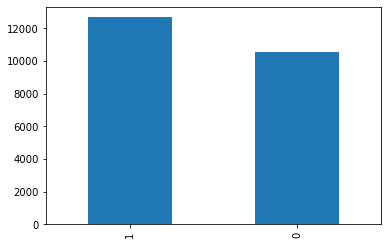

In [11]:
# train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(Label) 값의 분포
train_data['Label'].value_counts().plot(kind = 'bar')

In [12]:
# 'Label'의 값이 정확히 몇개인지 확인
print(train_data.groupby('Label').size().reset_index(name = 'count'))

### 부정:: 1881, 긍정:: 12528 ###

   Label  count
0      0  10522
1      1  12673


In [13]:
# train_data 결측값 확인
train_data.isna().sum()

아이디      0
리뷰       0
Label    0
dtype: int64

### 결측값 위치 확인
train_data.loc[train_data.document.isnull()]

### 결측값 제거
#### Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 
#### Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 

## 데이터 전처리

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:50]

,아이디,리뷰,Label
11464,pj**님,근본의 갈반핫반,0
26917,ch**님,배달도 빠르고 넘나맛나요 리뷰이벤트 감사합니다 ㅎㅎ,1
29438,cw**님,역시또랴오래예전이나지금이나너무맛나요,1
2339,rl**님,맛과 양 어느 것 하나 빠지지 않습니다,0
2631,10**님,치킨에 온기가없이 식어서 왔네요 배달분찍으시고 그것보다 빨리오셔서 그래도 식지 않았...,0
17588,2d**님,맛은 괜찮은데 제입맛에는 조금 달게 느껴집니다 서비스로 튀김 잘머것어요,1
3969,da**님,바삭하지는 않아서 좀 눅눅항 상태였어요,0
5865,wl**님,감자튀김 너무 눅눅해요 ㅠㅠ,0
33635,do**님,굽내치킨 고추바사삭 완전 추천합니다,1
26310,ch**님,맛있었어요 본연그맛그대로 역시페리카나입니다,1


In [15]:
# 정규표현식 후 결측값 확인
train_data['리뷰'] = train_data['리뷰'].str.replace('^ +', "") 
train_data['리뷰'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

아이디        0
리뷰       398
Label      0
dtype: int64


In [16]:
# 결측값 확인
train_data.loc[train_data.리뷰.isnull()][:5]

,아이디,리뷰,Label
12510,손님,NaN,0
2837,손님,NaN,0
4778,di**님,NaN,0
12046,ch**님,NaN,0
2950,pe**님,NaN,0


In [17]:
# 결측값 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

22797


In [18]:
# test_data 또한 동일하게 전처리 진행

test_data.drop_duplicates(subset = ['리뷰'], inplace=True) # '리뷰'열에서 중복인 내용이 있다면 중복 제거
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['리뷰'] = test_data['리뷰'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['리뷰'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 6396


In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [20]:
okt = Okt()
okt.morphs('와 이런 것도 치킨이라고 차라리 닭가슴살을 만드는 게 나을 뻔', stem = True)

['오다',
 '이렇다',
 '것',
 '도',
 '치킨',
 '이라고',
 '차라리',
 '닭',
 '가슴',
 '살',
 '을',
 '만들다',
 '게',
 '나다',
 '뻔']

In [21]:
### 토큰화 후 X_train 에 저장 ###
X_train = []
for sentence in tqdm(train_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 22797/22797 [02:27<00:00, 154.04it/s]


In [22]:
print(X_train[:3])

[['근본', '갈다', '반', '핫반'], ['배달', '빠르다', '넘다', '맛', '나', '요', '리뷰', '이벤트', '감사하다', 'ㅎㅎ'], ['역시', '또랴', '오래', '예전', '이나', '지금', '이나', '너무', '맛', '나', '요']]


In [23]:
### 토큰화 후 X_test 에 저장 ###
X_test = []
for sentence in tqdm(test_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 6396/6396 [00:46<00:00, 137.84it/s]


### 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행한다

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
print(tokenizer.word_index)

{'먹다': 1, '맛있다': 2, '맛': 3, '배달': 4, '치킨': 5, '시키다': 6, '너무': 7, '좋다': 8, '보다': 9, '오다': 10, '자다': 11, '요': 12, '있다': 13, '많다': 14, '이다': 15, '다': 16, '주문': 17, '같다': 18, '안': 19, '시간': 20, '양': 21, '을': 22, '양념': 23, '로': 24, '없다': 25, '후라이드': 26, '만': 27, '감사하다': 28, '빠르다': 29, '진짜': 30, '않다': 31, '양도': 32, 'ㅎㅎ': 33, '또': 34, '소스': 35, '분': 36, '튀김': 37, '넘다': 38, '더': 39, '바삭': 40, '많이': 41, '하고': 42, '정말': 43, '서비스': 44, 'ㅠㅠ': 45, '리뷰': 46, '늦다': 47, '처음': 48, '네': 49, '닭': 50, '살': 51, '받다': 52, '되다': 53, '순': 54, '괜찮다': 55, '항상': 56, '다음': 57, '고': 58, '맵다': 59, '그냥': 60, '아니다': 61, '오늘': 62, '나다': 63, '반': 64, '역시': 65, '못': 66, '빨리': 67, '그렇다': 68, '생각': 69, '나': 70, '아쉽다': 71, '때': 72, '여기': 73, '주다': 74, '에서': 75, '짜다': 76, '서': 77, '엄청': 78, '걸리다': 79, '것': 80, '조금': 81, 'ㅠ': 82, '식다': 83, '최고': 84, '들다': 85, '다른': 86, '점': 87, '치즈볼': 88, '적다': 89, '님': 90, '이벤트': 91, '사진': 92, '두': 93, '믿다': 94, '제': 95, '인데': 96, '오래': 97, '잇다': 98, '자주': 99, '링클': 100, '떡': 101, '엔': 102,

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9803
등장 빈도가 2번 이하인 희귀 단어의 수: 5863
단어 집합에서 희귀 단어의 비율: 59.80822197286545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.8653306645444974


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3941


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
# 정수 인코딩이 되었는지 확인
print(X_train[:3])

[[1596, 443, 64, 811], [4, 29, 38, 3, 70, 12, 46, 91, 28, 33], [65, 97, 436, 265, 364, 265, 7, 3, 70, 12]]


In [30]:
# train_data에서 y_train과 y_test를 별도로 저장해준다
y_train = np.array(train_data['Label'])
y_test = np.array(test_data['Label'])

### 빈 샘플(empty samples) 제거
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [31]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [32]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print('X_train 샘플 제거 후 개수:',len(X_train))
print('y_train 샘플 제거 후 개수:',len(y_train))

X_train 샘플 제거 후 개수: 22678
y_train 샘플 제거 후 개수: 22678


### 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업 진행

리뷰의 최대 길이 : 100
리뷰의 평균 길이 : 10.656715759767176


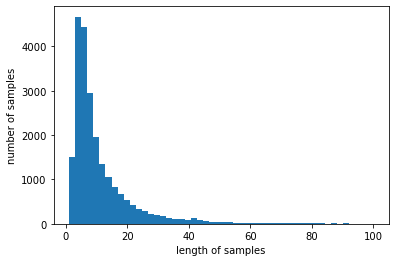

In [33]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 89이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.43513537348971


In [36]:
# 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인
# 모든 샘플의 길이를 30으로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
283/284 [============================>.] - ETA: 0s - loss: 0.3581 - acc: 0.8447
Epoch 1: val_acc improved from -inf to 0.91226, saving model to best_model.h5
284/284 [==============================] - 23s 69ms/step - loss: 0.3577 - acc: 0.8449 - val_loss: 0.2239 - val_acc: 0.9123
Epoch 2/15
283/284 [============================>.] - ETA: 0s - loss: 0.2603 - acc: 0.8967
Epoch 2: val_acc improved from 0.91226 to 0.92372, saving model to best_model.h5
284/284 [==============================] - 18s 63ms/step - loss: 0.2607 - acc: 0.8965 - val_loss: 0.2201 - val_acc: 0.9237
Epoch 3/15
283/284 [============================>.] - ETA: 0s - loss: 0.2463 - acc: 0.9017
Epoch 3: val_acc improved from 0.92372 to 0.92747, saving model to best_model.h5
284/284 [==============================] - 18s 64ms/step - loss: 0.2461 - acc: 0.9018 - val_loss: 0.1967 - val_acc: 0.9275
Epoch 4/15
283/284 [============================>.] - ETA: 0s - loss: 0.2339 - acc: 0.9086
Epoch 4: val_acc did not im

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

200/200 [==============================] - 5s 19ms/step - loss: 0.3047 - acc: 0.8893

 테스트 정확도: 0.8893


In [39]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [79]:
sentiment_predict('배달도 느리고 치킨은 다 식어서 앞으로 여기서 안먹을거같네요..')

87.73% 확률로 부정 리뷰입니다.



In [83]:
sentiment_predict('역시 믿고 먹는 치느님')

99.99% 확률로 긍정 리뷰입니다.

